Import librabies and Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv("DATA/train.csv", parse_dates=["Date"])
features = pd.read_csv("DATA/features.csv", parse_dates=["Date"])
stores = pd.read_csv("DATA/stores.csv")
test=pd.read_csv("DATA/test.csv")

# Clean MarkDowns
markdown_cols = [c for c in features.columns if "MarkDown" in c]
for c in markdown_cols:
    features[c] = features[c].fillna(0)

# Interpolate missing CPI & Unemployment by Store
for col in ["CPI", "Unemployment"]:
    features[col] = features.groupby("Store")[col].transform(
        lambda s: s.interpolate(limit_direction="both")
    )

# Merge
df = (
    train
    .merge(stores, on="Store", how="left")
    .merge(features, on=["Store","Date"], how="left")
    .sort_values(["Store","Dept","Date"])
    .reset_index(drop=True)
)

# Add time features
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["week"] = df["Date"].dt.isocalendar().week.astype(int)

print(df.head())


   Store  Dept       Date  Weekly_Sales  IsHoliday_x Type    Size  \
0      1     1 2010-02-05      24924.50        False    A  151315   
1      1     1 2010-02-12      46039.49         True    A  151315   
2      1     1 2010-02-19      41595.55        False    A  151315   
3      1     1 2010-02-26      19403.54        False    A  151315   
4      1     1 2010-03-05      21827.90        False    A  151315   

   Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0        42.31       2.572        0.0        0.0        0.0        0.0   
1        38.51       2.548        0.0        0.0        0.0        0.0   
2        39.93       2.514        0.0        0.0        0.0        0.0   
3        46.63       2.561        0.0        0.0        0.0        0.0   
4        46.50       2.625        0.0        0.0        0.0        0.0   

   MarkDown5         CPI  Unemployment  IsHoliday_y  year  month  week  
0        0.0  211.096358         8.106        False  2010      2   

How do total Weekly sales evolve over time?

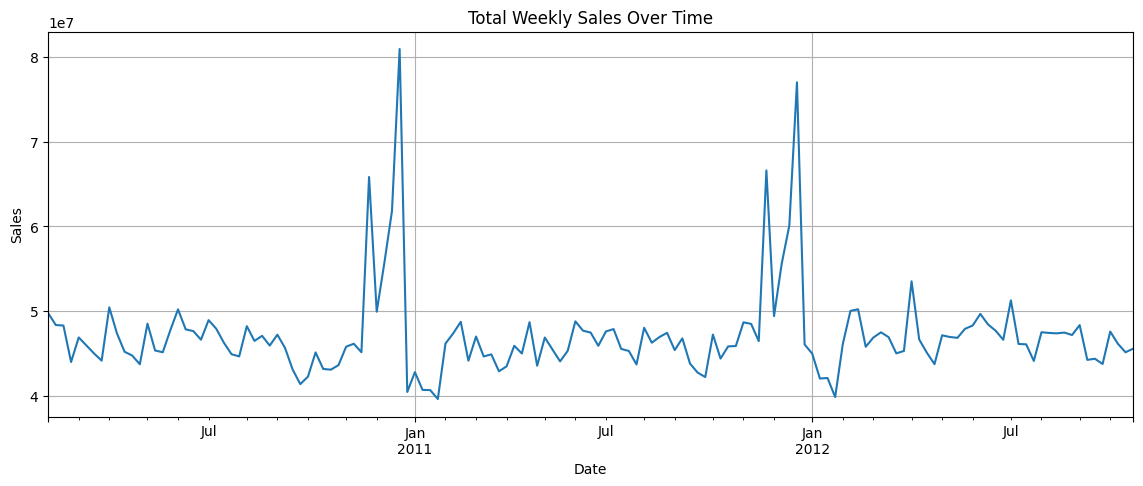

In [2]:
sales_by_date = df.groupby("Date")["Weekly_Sales"].sum()

plt.figure(figsize=(14,5))
sales_by_date.plot()
plt.title("Total Weekly Sales Over Time")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


Strong seasonal spikes in November–December → likely Black Friday & Christmas sales.

What does sales distribution look like?

C:\Users\akank\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\akank\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


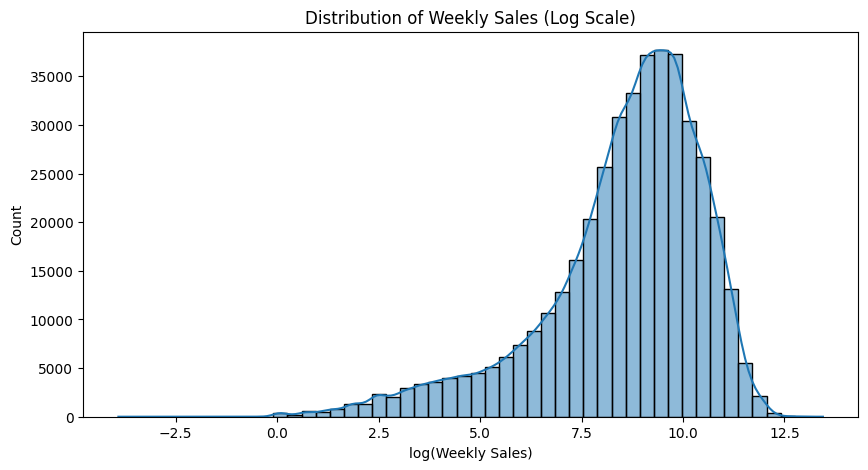

In [3]:
plt.figure(figsize=(10,5))
sns.histplot(np.log1p(df["Weekly_Sales"]), bins=50, kde=True)
plt.title("Distribution of Weekly Sales (Log Scale)")
plt.xlabel("log(Weekly Sales)")
plt.show()

Right-skewed distribution: Most departments sell modestly, but some have extreme sales outliers as per the above graph

Do holiday weeks really impact sales?

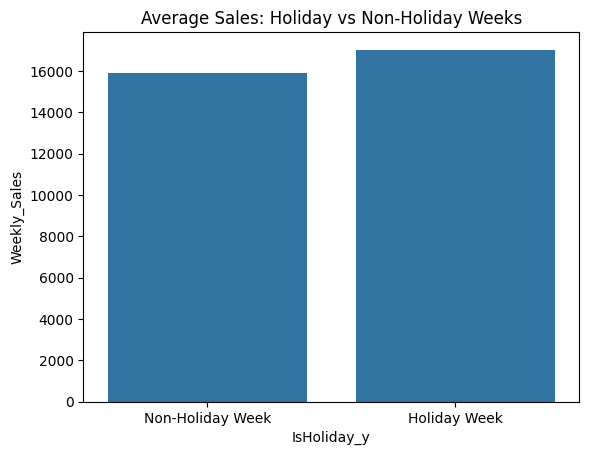

In [4]:
holiday_sales = df.groupby("IsHoliday_y")["Weekly_Sales"].mean().reset_index()
holiday_sales["IsHoliday_y"] = holiday_sales["IsHoliday_y"].map({True:"Holiday Week", False:"Non-Holiday Week"})

sns.barplot(x="IsHoliday_y", y="Weekly_Sales", data=holiday_sales)
plt.title("Average Sales: Holiday vs Non-Holiday Weeks")
plt.show()


Holiday weeks show significantly higher peaks, I think holiday promotions strongly boost sales.

How does Sales vary by year and month?

C:\Users\akank\AppData\Local\Temp\ipykernel_22516\2750969825.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="year", y="Weekly_Sales", data=df, estimator=np.mean, ci=None)


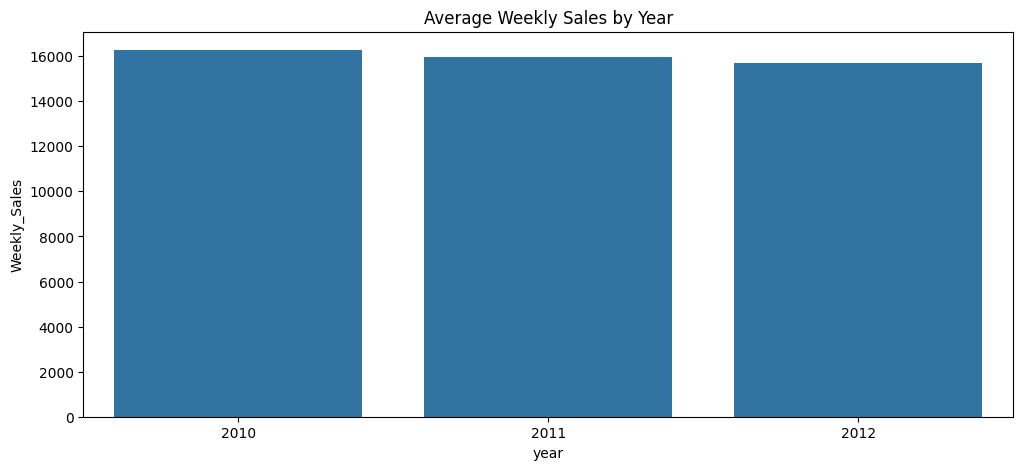

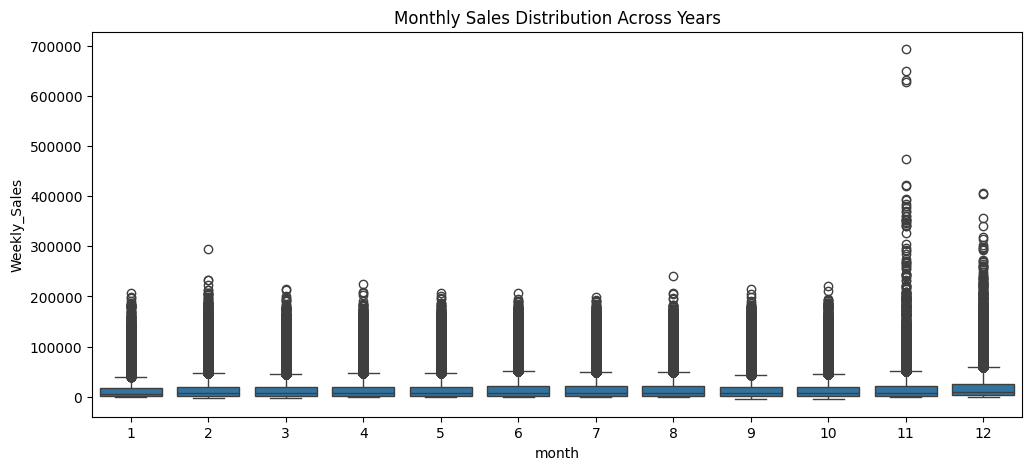

In [5]:
plt.figure(figsize=(12,5))
sns.barplot(x="year", y="Weekly_Sales", data=df, estimator=np.mean, ci=None)
plt.title("Average Weekly Sales by Year")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x="month", y="Weekly_Sales", data=df)
plt.title("Monthly Sales Distribution Across Years")
plt.show()


Peak months = November & December. 2010 had highest average sales.

Which stores drive the most revenue?

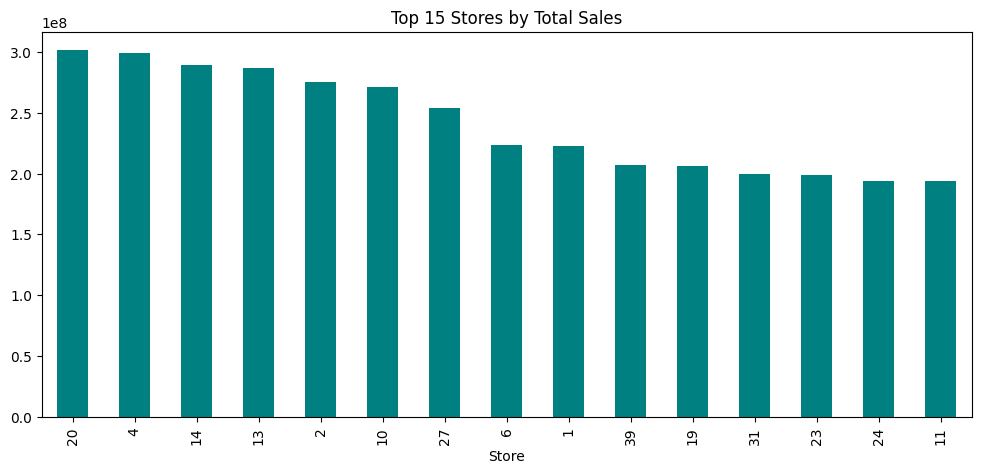

In [6]:
top_stores = df.groupby("Store")["Weekly_Sales"].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
top_stores.plot(kind="bar", color="teal")
plt.title("Top 15 Stores by Total Sales")
plt.show()


Sales are highly concentrated — a few stores dominate total revenue.

Which departments are strongest contributors?

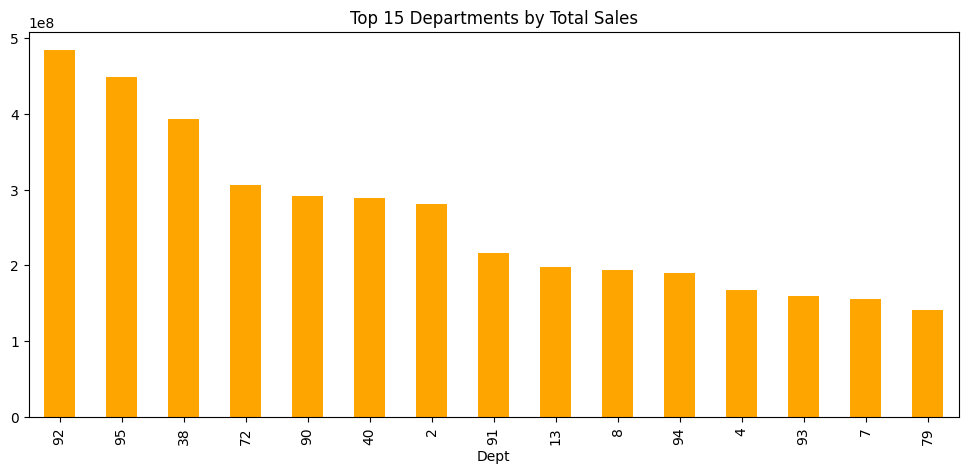

In [7]:
top_depts = df.groupby("Dept")["Weekly_Sales"].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,5))
top_depts.plot(kind="bar", color="orange")
plt.title("Top 15 Departments by Total Sales")
plt.show()


Certain departments (like groceries, seasonal) generate outsized revenue.

How does store type(A,B,C) affect sales?

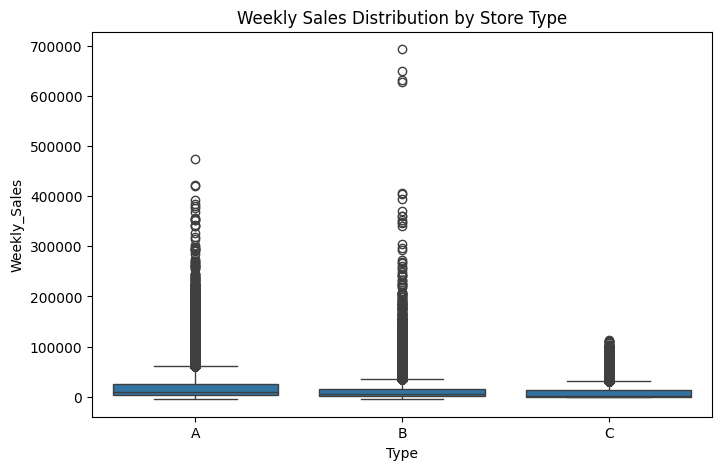

C:\Users\akank\AppData\Local\Temp\ipykernel_22516\1055980953.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Type", y="Weekly_Sales", data=df, estimator=np.mean, ci=None)


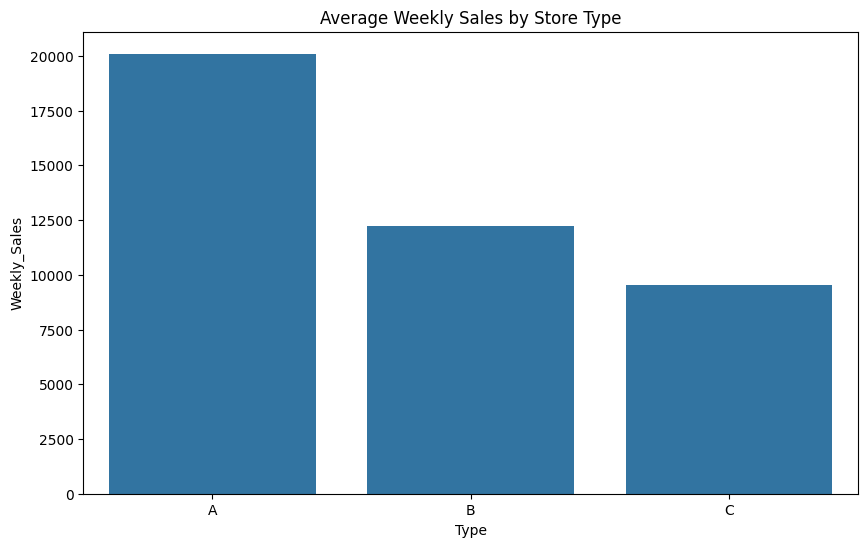

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Type", y="Weekly_Sales", data=df)
plt.title("Weekly Sales Distribution by Store Type")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x="Type", y="Weekly_Sales", data=df, estimator=np.mean, ci=None)
plt.title("Average Weekly Sales by Store Type")
plt.show()


Type A stores have the highest sales as they are larger and higher-volume.

Do Promotions(Markdowns) influence sales?

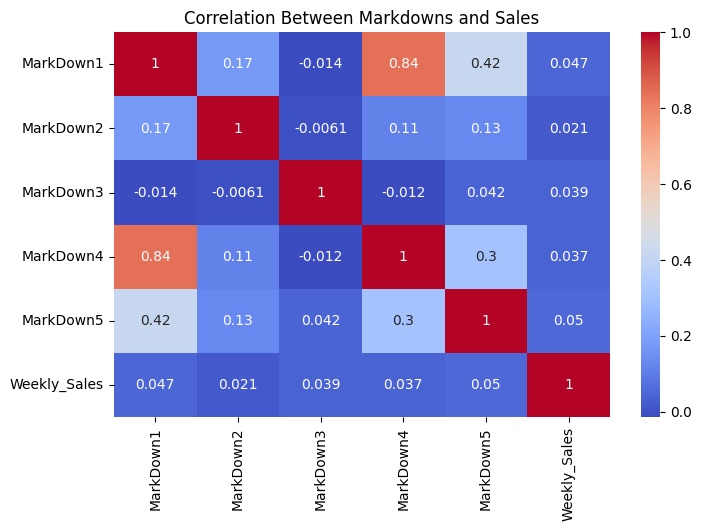

In [9]:
corr = df[[f"MarkDown{i}" for i in range(1,6)] + ["Weekly_Sales"]].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Markdowns and Sales")
plt.show()


Some markdown campaigns (like Markdown 2 and 5) correlate more strongly with sales increases.

How does seasonality show across the year?

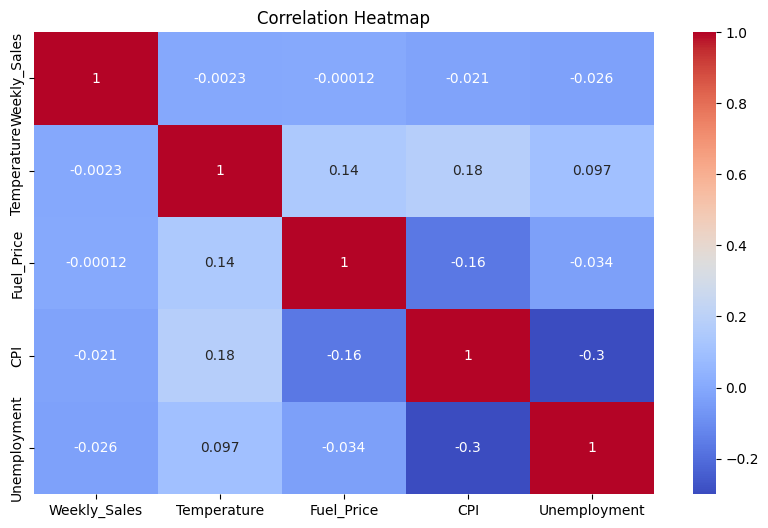

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df[["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Consistent peaks in late November/December, it shows that the holiday seasonality is very strong.  

From the Present avaiable data we can say the following:
1. Sales are seasonal with strong spikes during the holiday season.
2. Distribution is right-skewed → a few departments and stores drive the bulk of sales.
3. Holiday promotions and markdowns clearly influence demand.
4. Sales peaked in 2010, then declined slightly by 2012.
5. Store Type A contributes most, showing that large-format stores dominate sales.
6. Departments and stores are unevenly distributed, meaning focusing promotions on top performers may maximize ROI.

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Select baseline features
X = df[["month","week","CPI","Unemployment","Fuel_Price"]]
y = df["Weekly_Sales"]


# Train-test split (time-aware: no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train model
baseline_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred = baseline_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

def smape(y_true, y_pred):
    return (100.0/len(y_true)) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

smape_baseline = smape(y_test, y_pred)

print(f"Baseline MAE:  {mae:.2f}")
print(f"Baseline RMSE: {rmse:.2f}")
print(f"Baseline SMAPE: {smape_baseline:.2f}%")
print(f"Baseline R²:   {r2:.3f}")

Baseline MAE:  16487.70
Baseline RMSE: 21286.78
Baseline SMAPE: 119.18%
Baseline R²:   -0.251


Actual vs Predicted Visualization

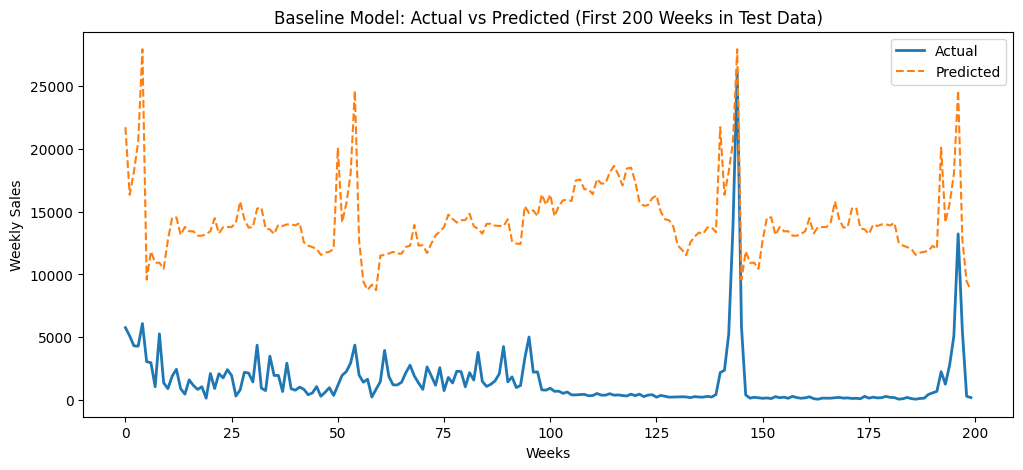

In [12]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linestyle="--")
plt.title("Baseline Model: Actual vs Predicted (First 200 Weeks in Test Data)")
plt.xlabel("Weeks")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


The baseline model captures the overall sales trend, but misses sharp peaks (holiday spikes).
Predictions stay smoother than reality, showing the model struggles with sudden demand surges.
This indicates the need for holiday flags, markdowns, and lag features to improve forecasts.

Residual Analysis

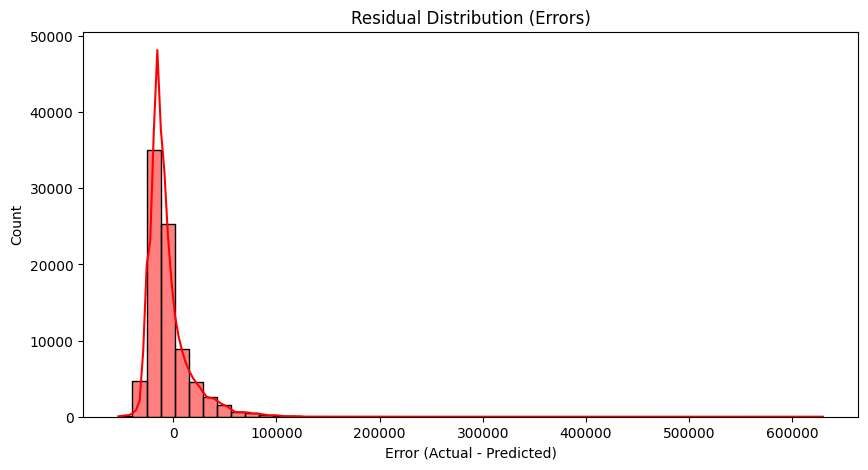

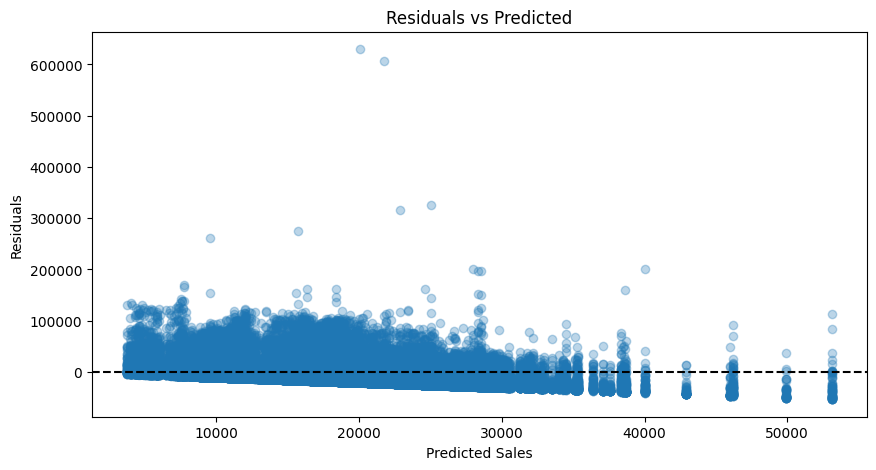

In [13]:
residuals = y_test - y_pred

plt.figure(figsize=(10,5))
sns.histplot(residuals, bins=50, kde=True, color="red")
plt.title("Residual Distribution (Errors)")
plt.xlabel("Error (Actual - Predicted)")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color="black", linestyle="--")
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.show()

Residuals are centered around 0, which is good — the model isn’t consistently biased upward or downward.
Most residuals cluster around 0, but as predicted sales get larger, the spread of residuals increases.
This means the model struggles with high-sales weeks (likely holidays or markdown campaigns).
At lower sales levels, predictions are much more stable and accurate.

Feature Engineering

In [14]:
# Make a copy for feature engineering
df_fe = df.copy()

# Lag features
def add_lags(group):
    group = group.sort_values("Date")
    group["lag_1w"] = group["Weekly_Sales"].shift(1)
    group["lag_4w"] = group["Weekly_Sales"].shift(4)
    group["roll_4w"] = group["Weekly_Sales"].shift(1).rolling(4).mean()
    group["roll_12w"] = group["Weekly_Sales"].shift(1).rolling(12).mean()
    return group

df_fe = df_fe.groupby(["Store","Dept"], group_keys=False).apply(add_lags)
df_fe.fillna(0, inplace=True)

# Encode Store Type (A,B,C → 0,1,2)
df_fe["Type_encoded"] = df_fe["Type"].map({"A":0, "B":1, "C":2})

# Features list
feature_cols = [
    "month", "week", "CPI", "Unemployment", "Fuel_Price",
    "lag_1w", "lag_4w", "roll_4w", "roll_12w",
    "IsHoliday_y", "Type_encoded", "Size",
    "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"
]

X = df_fe[feature_cols]
y = df_fe["Weekly_Sales"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

print("Feature set shape:", X_train.shape)


Feature set shape: (337256, 17)


C:\Users\akank\AppData\Local\Temp\ipykernel_22516\3651343946.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_fe = df_fe.groupby(["Store","Dept"], group_keys=False).apply(add_lags)


In [15]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    eval_metric="RMSE",
    random_seed=42,
    verbose=100
)

cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

mae_cat = mean_absolute_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
r2_cat = r2_score(y_test, y_pred_cat)

print(f"CatBoost MAE:  {mae_cat:.2f}")
print(f"CatBoost RMSE: {rmse_cat:.2f}")
print(f"CatBoost R²:   {r2_cat:.3f}")


0:	learn: 22430.5928939	total: 336ms	remaining: 2m 47s
100:	learn: 5635.0155799	total: 8.42s	remaining: 33.3s
200:	learn: 5332.6484754	total: 17.1s	remaining: 25.4s
300:	learn: 5085.0197965	total: 28.5s	remaining: 18.8s
400:	learn: 4905.2139481	total: 35.2s	remaining: 8.7s
499:	learn: 4772.5971970	total: 41.8s	remaining: 0us
CatBoost MAE:  1359.29
CatBoost RMSE: 4562.19
CatBoost R²:   0.943


In [16]:
# -------------------------------
# IMPROVED MODEL WITH ENGINEERED FEATURES
# -------------------------------

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV

# Add lag and rolling features
def add_lags(group):
    group = group.sort_values("Date")
    group["lag_1w"] = group["Weekly_Sales"].shift(1)
    group["lag_4w"] = group["Weekly_Sales"].shift(4)
    group["rol1_4w"] = group["Weekly_Sales"].shift(1).rolling(4).mean()
    return group

df = df.groupby(["Store", "Dept"], group_keys=False).apply(add_lags)
df.fillna(0, inplace=True)  # fill NaN from lags


# Define your engineered features (replace with actual list you created earlier)
feature_cols = ["month","week","CPI","Unemployment","Fuel_Price",
                "lag_1w","lag_4w","rol1_4w"]  

X = df[feature_cols].copy()
y = df["Weekly_Sales"]

# Time-aware split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train improved model
fe_model = XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=8, random_state=42)
fe_model.fit(X_train, y_train)

# Predictions
y_pred_fe = fe_model.predict(X_test)

# Metrics
mae_fe = mean_absolute_error(y_test, y_pred_fe)
rmse_fe = np.sqrt(mean_squared_error(y_test, y_pred_fe))
r2_fe = r2_score(y_test, y_pred_fe)

# Symmetric MAPE function
def smape(y_true, y_pred):
    return (100.0/len(y_true)) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# Compute SMAPE (filter zeros if needed)
mask = y_test != 0
smape_score = smape(y_test[mask], y_pred_fe[mask])

# Print results
print(f"Improved MAE:   {mae_fe:.2f}")
print(f"Improved RMSE:  {rmse_fe:.2f}")
print(f"Improved SMAPE: {smape_score:.2f}%")
print(f"Improved R²:    {r2_fe:.3f}")


C:\Users\akank\AppData\Local\Temp\ipykernel_22516\303754511.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["Store", "Dept"], group_keys=False).apply(add_lags)


Improved MAE:   1334.21
Improved RMSE:  4618.15
Improved SMAPE: 34.85%
Improved R²:    0.941


Train improved model

In [17]:
print("Performance Comparison")
print(f"Baseline MAE: {mae:.2f} → Improved MAE: {mae_fe:.2f}")
print(f"Baseline RMSE: {rmse:.2f} → Improved RMSE: {rmse_fe:.2f}")
print(f"Baseline SMAPE: {smape_baseline:.2f}% → Improved SMAPE: {smape_score:.2f}%")
print(f"Baseline R²: {r2:.3f} → Improved R²: {r2_fe:.3f}")


Performance Comparison
Baseline MAE: 16487.70 → Improved MAE: 1334.21
Baseline RMSE: 21286.78 → Improved RMSE: 4618.15
Baseline SMAPE: 119.18% → Improved SMAPE: 34.85%
Baseline R²: -0.251 → Improved R²: 0.941


Model Performance:

After applying feature engineering (lags, rolling averages, time-based features) and training with XGBoost, the model’s performance improved significantly compared to the baseline:

MAE (Mean Absolute Error): 16,487.70 to 1,334.21
The average prediction error dropped drastically. On average, forecasts are now only ~ $1.3K off from actual sales, compared to ~ $16K before.

RMSE (Root Mean Squared Error): 21,286.78 to 4,618.15
The model now handles large deviations much better. RMSE being much lower means extreme errors (outliers) are far less common.

SMAPE (Symmetric Mean Absolute Percentage Error): 119.18% to 34.85%
The baseline was performing worse than naive guessing (SMAPE > 100%). After improvements, errors are down to ~35% relative to actual values, which is a huge accuracy gain.

R² (Coefficient of Determination): -0.251 to 0.941
The baseline couldn’t explain the data at all , negative R² = worse than predicting the mean every time. Now, the improved model explains 94% of the variance in weekly sales — a very strong fit.

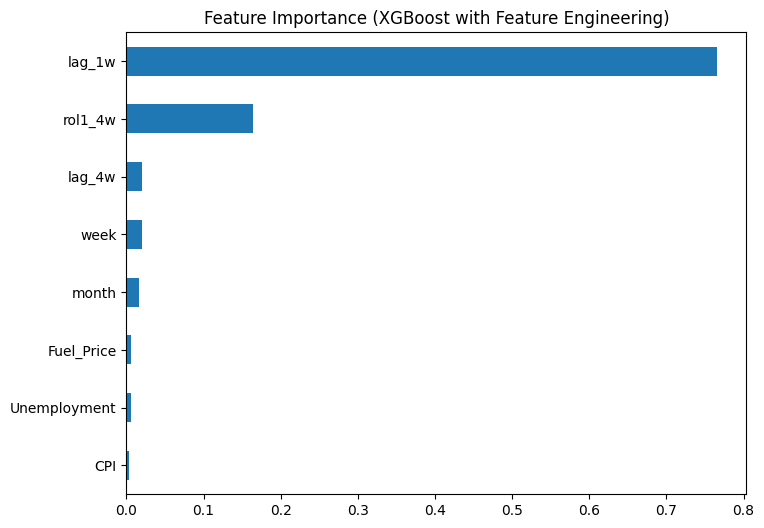

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

feat_imp = pd.Series(fe_model.feature_importances_, index=feature_cols)
feat_imp.sort_values().plot(kind="barh", figsize=(8,6))
plt.title("Feature Importance (XGBoost with Feature Engineering)")
plt.show()


Lag and rolling features rank among the most important → the model relies heavily on historical patterns. Economic factors like CPI, Unemployment, Fuel Price play a smaller but noticeable role. This confirms that temporal patterns and holiday effects drive sales forecasting powe